# Parse the Dataset
Read all Al data, store it in pkl formats for quick access later

In [1]:
%matplotlib inline
import sys
from glob import glob
# sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from ase.io import qbox, cube
from ase.visualize import view
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from stopping_power_ml.io import load_directory, get_charge_density_interpolator
import pandas as pd
import numpy as np
import pickle as pkl
import os
import time
import gzip

Configure parsl

In [2]:
import parsl
# from parsl.configs.local_ipp import config
from parsl.configs.local_threads import config
from parsl.app.app import python_app
dfk = parsl.load(config)

## Read in an Output File
Read in one of the files from the `v = 1.0` calculation.

In [3]:
%%time
# data = qbox.read_qbox(os.path.join('datasets', '256_Al', 'Dv1.0', 'kpgenlong_sd_psd_combo_r17_111_cutoff_50_1.out'))
dir = "datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv1.0/"
data = qbox.read_qbox(f"{dir}/kpgenlong_sd_psd_combo_r17_111_cutoff_50_1.out")

CPU times: user 5.19 s, sys: 311 ms, total: 5.5 s
Wall time: 5.68 s


Save the frame for later use

In [4]:
pkl.dump(data, open('al_starting_frame.pkl', 'wb'))

The output file is a large Al lattice, as expected.

The following figure shows the atomic structure for the first timestep of the simulation. The red particle is the proton projectile.

In [5]:
view_data = data.copy()
view_data[-1].set('symbol', 'O')
view(view_data, viewer='x3d')

## Read the Electron Density File
The `Al_semi_core_gs.cube` contains the electron density for Aluminum in its ground state before introducing the particle, as computed using Density Functional Theory. We plan to use this data as input into the machine learning model.

In [6]:
%%time
density, cube_atoms = get_charge_density_interpolator(f'{dir}/../Al_semi_core_gs.cube')
with open('density_interp-nosym.pkl', 'wb') as fp:
    pkl.dump(density, fp)

CPU times: user 922 ms, sys: 66.2 ms, total: 989 ms
Wall time: 1.26 s


One issue with the charge density data is that it does not exactly obey the symemtries of the lattice. To remedy this, we create an interpolator that enforces this symmetry. 

In [7]:
%%time
sym_density, cube_atoms = get_charge_density_interpolator(f'{dir}/../Al_semi_core_gs.cube',
                                                          symmetry=True, sym_accuracy=12)

CPU times: user 3.4 s, sys: 69.1 ms, total: 3.47 s
Wall time: 3.51 s


### Make Sure the Interpolator has the Correct Symmetry
The charge density should have the same symmetry as the lattice. In this part, we make sure that is the case.

In [8]:
def make_density_plot(ax, center, vec1, vec2, density, dist=0.4, offset=[0,0,0], colorbar = False):
    # Compute the normal vectors
    vec1 = np.array(vec1) / np.linalg.norm(vec1)
    vec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Make the grid
    spacings = np.linspace(-dist, dist, 128)
    xs, ys = np.meshgrid(spacings, spacings)
    points = np.array([i * vec1 + j * vec2 + center for i,j in zip(xs.flatten(), ys.flatten())])
    points = points % 1
    
    # Make the plots
    chg_density = density(np.add(points, offset)).reshape(xs.shape)
    pct = ax.pcolor(xs, ys, chg_density, vmin=0, vmax=3, cmap='Blues')
    if colorbar:
        plt.colorbar(pct)
    ax.set_xticks([])
    ax.set_yticks([])
    return chg_density

Plot the $xz$-plane centered around [0,0,0], plot the difference between the charge density on the $yz$ plane centered at a different point in the lattice

Unsymmetrized maximum difference: 0.0004397829995639313
Symmetrized maximum difference: 3.4638958368304884e-14
CPU times: user 12.9 s, sys: 8.21 ms, total: 12.9 s
Wall time: 13 s


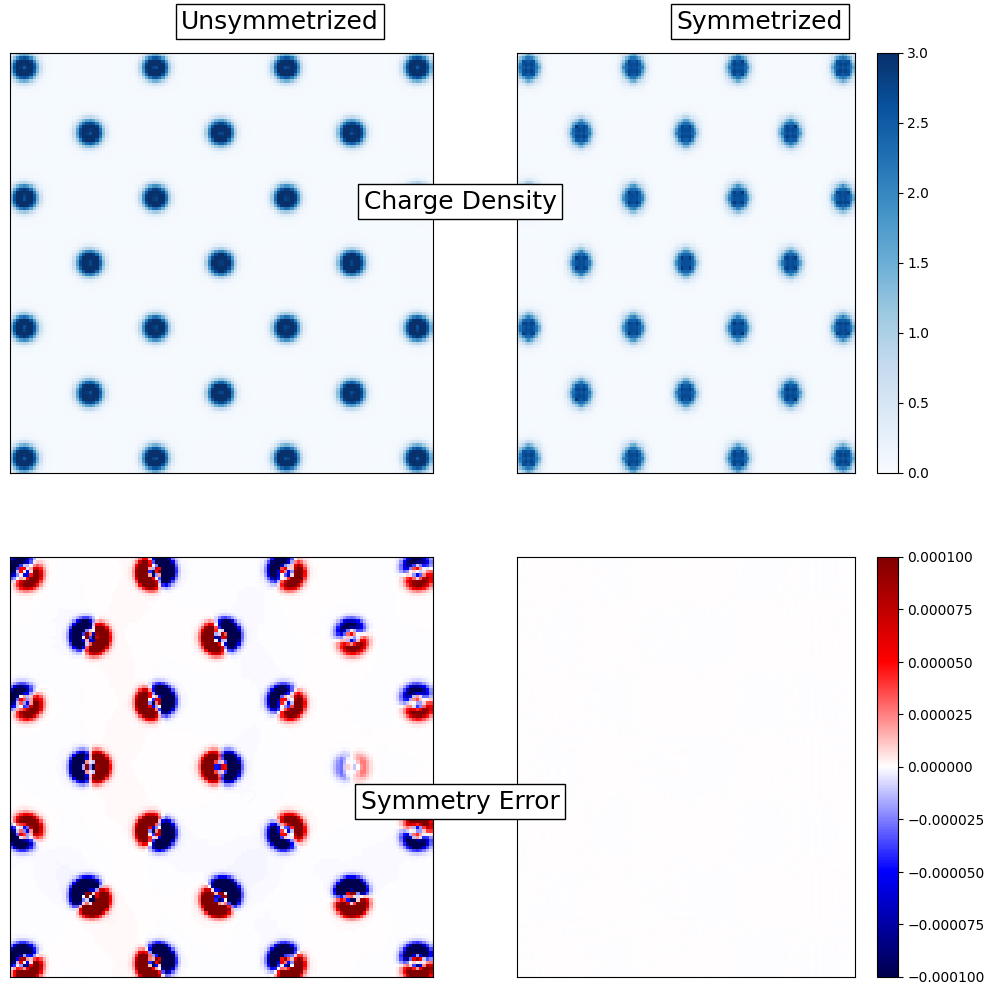

In [9]:
%%time
fig, ax = plt.subplots(2, 2)

fig.text(0.5, 0.75, 'Charge Density', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})
fig.text(0.5, 0.25, 'Symmetry Error', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the unsymmetrized and its density difference
density_shifted = make_density_plot(ax[0,0], [0,0,0], [0,0,1], [-1,0,0], density)
density_zero = make_density_plot(ax[0,0], [0.25,0,0.75], [0,0,1], [0,1,0], density)
print('Unsymmetrized maximum difference:', np.abs(density_shifted-density_zero).max())
d = ax[1,0].pcolor(density_shifted-density_zero, vmin=-1e-4, vmax=1e-4, cmap='seismic')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.text(0.35, 0.9, 'Unsymmetrized', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the symmetrized and its density difference
density_shifted = make_density_plot(ax[0,1], [0,0,0], [0,0,1], [-1,0,0], sym_density)
density_zero = make_density_plot(ax[0,1], [0.25,0,0.75], [0,0,1], [1,0,0], sym_density, colorbar = True)
print('Symmetrized maximum difference:', np.abs(density_shifted-density_zero).max())
d = ax[1,1].pcolor(density_shifted-density_zero, vmin=-1e-4, vmax=1e-4, cmap='seismic')
plt.colorbar(d)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.text(0.75, 0.9, 'Symmetrized', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

fig.set_size_inches(12, 12)

*Finding*: This upper row of the plot shows the charge density along the $xy$-plane of the simulation cell, which shows the expected pattern for [100] of the FCC structure. The bottom row shows the difference between this density, and the density computed on an equivalent plane in the structure, which illustrates the broken symmetries for the 'unsymmetrized' interpolation scheme.

### Decide on number of grid points
Figure out how fine the interpolation grid should be by measuring the maximimum interpolation error over the simulation cell

Determine the 'true' answer

In [10]:
eval_points = np.meshgrid(*(np.linspace(0,1,32),)*3)
eval_points = np.array(list(zip(*[f.ravel() for f in eval_points])))

In [11]:
%%time
unsym_results = density(eval_points)

CPU times: user 5.47 ms, sys: 0 ns, total: 5.47 ms
Wall time: 5.47 ms


Measure the max error as a function of system size

In [12]:
@python_app
def evaluate_interpolator(i_size, eval_points, unsym_results):
    # Load in libraries
    from stopping_power_ml.io import get_charge_density_interpolator
    import time
    import numpy as np
    import os
    
    # Create the interpolator
    create_time = time.time()
    sym_density, cube_atoms = get_charge_density_interpolator(f'{dir}/../Al_semi_core_gs.cube',
                                                              symmetry=True, sym_accuracy=i_size)
    create_time -= time.time()
    
    # Run on the same points as the unsym 
    run_time = time.time()
    sym_results = sym_density(eval_points)
    run_time -= time.time()
    
    print(create_time*-1, run_time*-1)
    
    return -1 * create_time, -1 * run_time, np.max(np.abs(sym_results-unsym_results))

In [13]:
%%time
sym_size = list(range(10, 32, 10))
test_result_futures = [evaluate_interpolator(x, eval_points, unsym_results) for x in sym_size]

CPU times: user 98.3 ms, sys: 52 ms, total: 150 ms
Wall time: 150 ms
4.454042196273804 24.52642798423767
58.54408240318298 24.712182760238647
299.31015038490295 12.146161794662476


In [14]:
%%time
create_times, run_times, max_errors = zip(*[r.result() for r in tqdm(test_result_futures)])

<timed exec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 5min 39s, sys: 171 ms, total: 5min 40s
Wall time: 5min 40s


Plot the errors and the timings

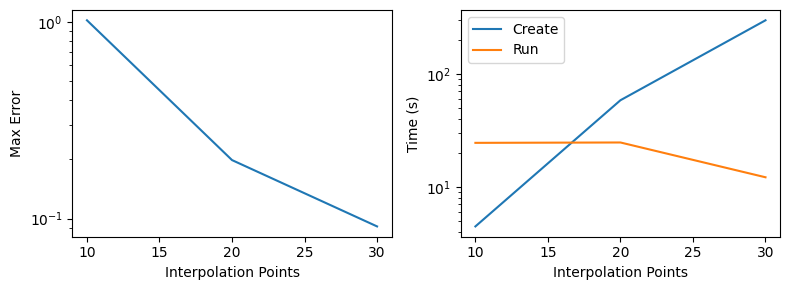

In [15]:
fig, ax = plt.subplots(1, 2)
ax[0].semilogy(sym_size, max_errors)
ax[0].set_ylabel('Max Error')
ax[0].set_xlabel('Interpolation Points')

ax[1].semilogy(sym_size, create_times, label='Create')
ax[1].semilogy(sym_size, run_times, label='Run')
ax[1].set_xlabel('Interpolation Points')
ax[1].set_ylabel('Time (s)')
ax[1].legend()

fig.set_size_inches(8, 3)
fig.tight_layout()

Find when the error is less than 1% of the maximum value of the charge density

In [16]:
below_thr = [x / np.max(unsym_results) < 0.025 for x in max_errors]
if any(below_thr):
    best_size = sym_size[below_thr.index(True)] # Finds the smallest. `index` finds the first, these are ordered by size
else:
    best_size = sym_size[np.argmin(max_errors)]
print('Optimal interpolator size:', best_size)

Optimal interpolator size: 30


Make sure the symmetrized output is the same as the unsymmetrized. Focus on the region around an atom

In [17]:
%%time
sym_density, cube_atoms = get_charge_density_interpolator(f'{dir}/../Al_semi_core_gs.cube',
                                                          symmetry=True, sym_accuracy=best_size)

CPU times: user 4min 29s, sys: 96 ms, total: 4min 29s
Wall time: 4min 29s


Maximum difference: 0.2241 (6.87%)
CPU times: user 6.51 s, sys: 6 ms, total: 6.52 s
Wall time: 6.52 s


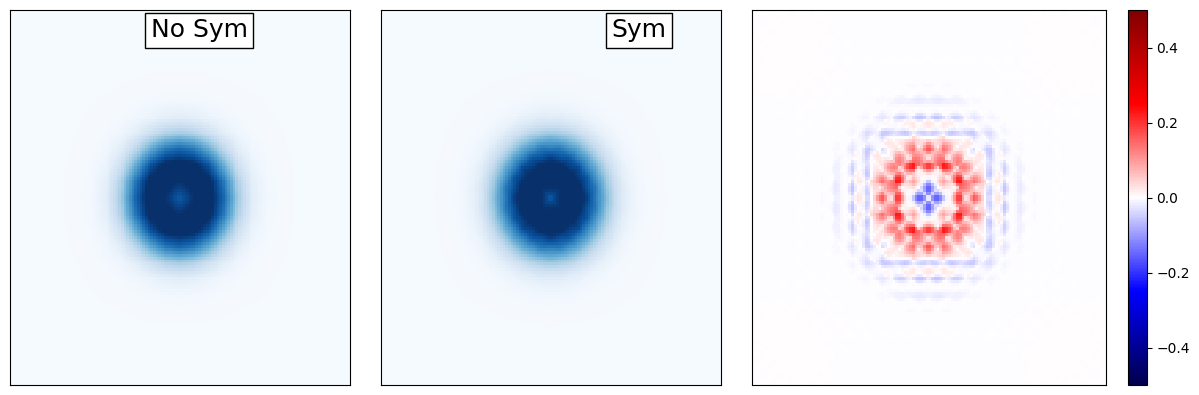

In [18]:
%%time
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1,1,1.3]})

fig.text(1.0/6, 0.9, 'No Sym', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})
fig.text(0.5, 0.9, 'Sym', fontsize=18, ha='center',
        bbox={'facecolor':'w', 'edgecolor': 'k'})

# Plot the unsymmetrized and its density difference
density_nosym = make_density_plot(ax[0], [0,0,0], [0,0,1], [0,1,0], density, 0.08)
density_sym = make_density_plot(ax[1], [0,0,0], [0,0,1], [0,1,0], sym_density, 0.08)
print('Maximum difference: %.4f (%.2f%%)'%(np.abs(density_nosym-density_sym).max(), 
                                           np.abs(density_nosym-density_sym).max() / np.max(density_nosym) * 100))
d = ax[2].pcolor(density_nosym-density_sym, vmin=-0.5, vmax=0.5, cmap='seismic')
fig.colorbar(d)
ax[2].set_xticks([])
ax[2].set_yticks([])

fig.tight_layout()
fig.set_size_inches(12 * 1.1, 4)

Save the interpolator for later use

In [19]:
pkl.dump(sym_density, open('density_interp.pkl', 'wb'))

## Load in Datasets
We need to read in several things from each file:

1. The energy of the system
1. The atomic structure in that frame
1. The location, velocity, and force acting on the particle

## Get Data from 2015 Study
This has a particular naming system: all files with data are named `kpg*.out`

Find all the directories containing QBOX data

In [10]:
dirs = set([os.path.dirname(x) for x in glob("datasets/schleife_accurate_atomistic_stopping_v1.1/*Al*/**/kpg*out", recursive=True)])
print(dirs)

{'datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv2.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv0.5', 'datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv3.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv3.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv1.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv0.5', 'datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv4.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv4.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv2.0', 'datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv1.0'}


In [11]:
data = []
for file in tqdm(dirs, desc='Directory'):
    print(file)
    frame = load_directory(file, prefix="kpg*")
    frame['file'] = file
    data.append(frame)
data = pd.concat(data)
print('Read in %d training points'%len(data))

/tmp/ipykernel_96538/1149876363.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(dirs, desc='Directory'):


Directory:   0%|          | 0/10 [00:00<?, ?it/s]

datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv2.0
(8000, 3) [[0.00000000e+00 5.74196597e+00 5.74196597e+00]
 [6.63869000e-03 5.76056331e+00 5.76261049e+00]
 [1.32773800e-02 5.77916065e+00 5.78325501e+00]
 ...
 [5.30895957e+01 1.54464890e+02 1.70836211e+02]
 [5.30962344e+01 1.54483487e+02 1.70856856e+02]
 [5.31028731e+01 1.54502084e+02 1.70877500e+02]]
datasets/schleife_accurate_atomistic_stopping_v1.1/Al_256_channel/Dv0.5
(5000, 3) [[0.00000000e+00 5.74196597e+00 5.74196597e+00]
 [7.14200000e-03 5.74196597e+00 5.74196597e+00]
 [1.42840000e-02 5.74196597e+00 5.74196597e+00]
 ...
 [3.56885740e+01 5.74196597e+00 5.74196597e+00]
 [3.56957160e+01 5.74196597e+00 5.74196597e+00]
 [3.57028580e+01 5.74196597e+00 5.74196597e+00]]
datasets/schleife_accurate_atomistic_stopping_v1.1/256_Al/Dv3.0
(2269, 3) [[0.00000000e+00 5.74196597e+00 5.74196597e+00]
 [9.95803000e-03 5.76986192e+00 5.77293282e+00]
 [1.99160700e-02 5.79775787e+00 5.80389968e+00]
 ...
 [2.25649038e+01 6.89541934e+01 7

In [12]:
data.head()

,atoms,frame_id,force,position,velocity,energy,file_id,file,timestep,displacement,directory
0,"(Atom('Al', [11.48393195, 11.48393195, 7.65595...",0,-1.946322e-07,"[0.0, 5.74196597, 5.74196597]","[0.464764, 1.30197, 1.44529]",-18651.708437,1,datasets/schleife_accurate_atomistic_stopping_...,0,0.000000,datasets/schleife_accurate_atomistic_stopping_...
1,"(Atom('Al', [11.48393195, 11.48393195, 7.65595...",1,5.289108e-02,"[0.00663869, 5.76056331, 5.76261049]","[0.464764, 1.30197, 1.44529]",-18651.707679,1,datasets/schleife_accurate_atomistic_stopping_...,1,0.028568,datasets/schleife_accurate_atomistic_stopping_...
2,"(Atom('Al', [11.48393195, 11.48393195, 7.65595...",2,1.050037e-01,"[0.01327738, 5.77916065, 5.78325501]","[0.464764, 1.30197, 1.44529]",-18651.705409,1,datasets/schleife_accurate_atomistic_stopping_...,2,0.057136,datasets/schleife_accurate_atomistic_stopping_...
3,"(Atom('Al', [11.48393195, 11.48393195, 7.65595...",3,1.558200e-01,"[0.01991607, 5.79775799, 5.80389954]","[0.464764, 1.30197, 1.44529]",-18651.701654,1,datasets/schleife_accurate_atomistic_stopping_...,3,0.085704,datasets/schleife_accurate_atomistic_stopping_...
4,"(Atom('Al', [11.48393195, 11.48393195, 7.65595...",4,2.049363e-01,"[0.02655476, 5.81635533, 5.82454406]","[0.464764, 1.30197, 1.44529]",-18651.696452,1,datasets/schleife_accurate_atomistic_stopping_...,4,0.114272,datasets/schleife_accurate_atomistic_stopping_...


## Load in the New Data
We ran some additional calculations for this study, they are named differently. 

In [13]:
new_dirs = glob("datasets/schleife2018_v1.1/D*")
print(new_dirs)
print('Found {} new directories'.format(len(new_dirs)))

['datasets/schleife2018_v1.1/Dmod_v1.0', 'datasets/schleife2018_v1.1/Dmin_v1.0', 'datasets/schleife2018_v1.1/Drnddir2_v1.0', 'datasets/schleife2018_v1.1/Doptimal_v1.0']
Found 4 new directories


Load in the new data

In [14]:
new_data = []
for file in tqdm(new_dirs, desc='Directory'):
    print(file)
    frame = load_directory(file, prefix="output", suffix='run')
    frame['file'] = file
    new_data.append(frame)
new_data = pd.concat(new_data)
print('Read in %d training points from new trajectories'%len(new_data))

/tmp/ipykernel_96538/1816625414.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm(new_dirs, desc='Directory'):


Directory:   0%|          | 0/4 [00:00<?, ?it/s]

datasets/schleife2018_v1.1/Dmod_v1.0
(2000, 3) [[0.00000000e+00 5.74196250e+00 5.74196250e+00]
 [1.16628400e-02 5.74779392e+00 5.74779392e+00]
 [2.33256700e-02 5.75362534e+00 5.75362534e+00]
 ...
 [2.32906858e+01 1.73873054e+01 1.73873054e+01]
 [2.33023486e+01 1.73931368e+01 1.73931368e+01]
 [2.33140115e+01 1.73989682e+01 1.73989682e+01]]
datasets/schleife2018_v1.1/Dmin_v1.0
(2000, 3) [[ 3.4451775   3.827975    3.827975  ]
 [ 3.45126822  3.83711108  3.83711108]
 [ 3.45735894  3.84624715  3.84624715]
 ...
 [15.6083414  22.07272099 22.07272099]
 [15.61443212 22.08185707 22.08185707]
 [15.62052283 22.09099314 22.09099314]]
datasets/schleife2018_v1.1/Drnddir2_v1.0
(9800, 3) [[0.00000000e+00 5.74196597e+00 5.74196597e+00]
 [1.17652800e-02 5.74769446e+00 5.74769446e+00]
 [2.35305600e-02 5.75342294e+00 5.75342294e+00]
 ...
 [1.15264427e+02 6.18639538e+01 6.18639538e+01]
 [1.15276192e+02 6.18696823e+01 6.18696823e+01]
 [1.15287958e+02 6.18754108e+01 6.18754108e+01]]
datasets/schleife2018_v1.1/

Add new data to the old array

In [15]:
data = pd.concat([data, new_data])

Reset the indices of the DataFrame. Currently, the indices for each directory start from zero, which causes annoyances when looking up data

In [16]:
data.reset_index(drop=True, inplace=True)

### Save the Data as a Pickle
For use in later scripts

In [22]:
# print(data.keys())
data.drop('atoms', axis = 'columns').to_pickle(gzip.open('data.pkl.gz', 'wb'))

In [23]:
pkl.dump(data['atoms'].iloc[0], open('al_starting_frame.pkl', 'wb'))